In [1]:
from datetime import datetime
from multiprocessing import Pool

import time
import os
import sys
from pathlib import Path

import numpy as np
import scipy
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import astropy.units as u
from astropy.io import fits
from mmtwfs.wfs import WFSFactory

In [2]:
# instantiate all of the WFS systems...
wfs_keys = ['newf9', 'f5', 'mmirs']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name
plt.close('all')

In [5]:
def check_wfs(p):
    """
    Check to see which system was used on a given night
    """
    if Path.exists(p / "F9"):  # wow, i really like pathlib.Path...
        return "newf9"
    elif Path.exists(p / "F5"):
        return "f5"
    elif Path.exists(p / "MMIRS"):
        return 'mmirs'
    else:
        return None

def process_image(f):
    """
    Process FITS file, f, to get info we want from the header and then analyse it with the 
    appropriate WFS instance. Return results in a comma-separated line that will be collected 
    and saved in a CSV file.
    """
    if "ave" not in f.name:
        with fits.open(f) as h:
            hdr = h[0].header
            if 'AIRMASS' in hdr:
                airmass = hdr['AIRMASS']
            else:
                airmass = np.nan
            # we need to fix the headers in all cases to have a proper DATE-OBS entry with
            # properly formatted FITS timestamp.  in the meantime, this hack gets us what we need 
            # for analysis in pandas.
            if 'DATEOBS' not in hdr:
                return None
            dateobs = hdr['DATEOBS']
            ut = hdr['ut']
            timestring = dateobs + " " + ut + " UTC"
            dtime = datetime.strptime(timestring , "%a %b %d %Y %H:%M:%S %Z")
            obstime = dtime.isoformat()
            # being conservative here and only using data that has proper slope determination
            # and wavefront solution. also want to get statistics on the quality of the wavefront fits.
            results = wfs_systems[wfskey].measure_slopes(str(f), plot=False)
            if results['slopes'] is not None:
                zresults = wfs_systems[wfskey].fit_wavefront(results, plot=False)
                line = "%s,%s,%s,%f,%f,%f,%f,%f\n" % (
                    obstime,
                    wfskey,
                    f.name, 
                    airmass,
                    results['seeing'].value,
                    results['raw_seeing'].value,
                    results['fwhm'],
                    zresults['residual_rms'].value
                )
                zfile = f.parent / (f.stem + ".zernike")
                zresults['zernike'].save(filename=zfile)
                return line
            else:
                return None
    return None
#rootdir = Path("/Users/tim/MMT/wfsdat/test")
rootdir = Path("/Volumes/LaCie/wfsdat")

In [15]:
dirs = rootdir.glob("201709*")  # pathlib, where have you been all my life!
csv_header = "time,wfs,file,airmass,seeing,raw seeing,fwhm,wavefront rms\n"
for d in dirs:
    if d.is_dir():
        if Path.exists(d / "seeing_results.csv"):
            print("Already processed %s..." % d.name)
        else:
            try:
                lines = []
                lines.append(csv_header)
                night = int(d.name)  # valid WFS directories are ints of the form YYYYMMDD. if not this form, int barfs
                msg = "checking %d... " % night
                wfskey = check_wfs(d)
                if wfskey is not None:
                    if wfskey == "mmirs":
                        rawd = d / "rawdata"
                        if rawd.exists():
                            fitsfiles = rawd.glob("*.fits")
                        else:
                            fitsfiles = d.glob("*.fits")                
                    else:
                        fitsfiles = d.glob("*.fits")
                    msg += " using %s." % wfskey
                    print(msg)
                    #for f in fitsfiles:
                    #    print("Processing %s..." % f)
                    #   process_image(f)
                    with Pool(processes=8) as pool:  # my mac's i7 has 4 cores + hyperthreading so 8 virtual cores. 
                        plines = pool.map(process_image, fitsfiles)  # plines comes out in same order as fitslines!
                    plines = list(filter(None.__ne__, plines))  # trim out any None entries
                    lines.extend(plines)
                    with open(d / "seeing_results.csv", "w") as f:
                        f.writelines(lines)
                else:
                    msg = "No valid wfskey for %s..." % d
                    print(msg)
            except ValueError:  # this means running int(d.name) failed so it's not a valid directory...
                print("Skipping %s..." % d.name)

checking 20170901...  using mmirs.


Wavefront slope measurement failed: Only 62 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 65 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 8 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 26 spots detected out of 152 apertures.
/Users/tim/conda/envs/py36/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1301: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]
Wavefront slope measurement failed: Only 25 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 8 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 13 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 3 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 16 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 17 spots detected out of 129 apertures.
Wavefront 

checking 20170902...  using mmirs.


Wavefront slope measurement failed: Only 57 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 55 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 31 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 13 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 3 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 3 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 12 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 5 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 36 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 3 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 4 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 16 spots detected out of 129 apertures.
Wavefront slope measurement faile

checking 20170903...  using mmirs.


Wavefront slope measurement failed: Only 2 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 9 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 36 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 11 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 15 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 3 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 37 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 1 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 30 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 31 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 1 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 26 spots detected out of 129 apertures.
Wavefront slope measurement faile

checking 20170904...  using mmirs.
checking 20170905...  using mmirs.


Wavefront slope measurement failed: No WFS spots detected.
Wavefront slope measurement failed: Only 38 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 54 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 56 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 66 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 14 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 41 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 14 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 48 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 29 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 4 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 47 spots detected out of 152 apertures.
Wavefront slope measurement failed: No WFS spots de

checking 20170906...  using mmirs.


Wavefront slope measurement failed: Only 31 spots detected out of 129 apertures.
Wavefront slope measurement failed: Only 43 spots detected out of 129 apertures.
Wavefront slope measurement failed: No WFS spots detected.
Wavefront slope measurement failed: Only 2 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 1 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 2 spots detected out of 152 apertures.
Wavefront slope measurement failed: No WFS spots detected.
Wavefront slope measurement failed: No WFS spots detected.
Wavefront slope measurement failed: Only 3 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 3 spots detected out of 152 apertures.
Wavefront slope measurement failed: Only 5 spots detected out of 152 apertures.
Wavefront slope measurement failed: No WFS spots detected.
Wavefront slope measurement failed: Only 1 spots detected out of 152 apertures.
Wavefront slope measurement failed: No WFS

checking 20170907...  using mmirs.


Wavefront slope measurement failed: Only 2 spots detected out of 152 apertures.


checking 20170908...  using mmirs.
checking 20170909...  using f5.
Skipping 20170909...
checking 20170910...  using f5.
checking 20170911...  using f5.


Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 23 spots detected out of 175 apertures.


checking 20170912...  using f5.


Wavefront slope measurement failed: Only 2 spots detected out of 175 apertures.


checking 20170913...  using f5.


Wavefront slope measurement failed: Only 2 spots detected out of 175 apertures.


checking 20170914...  using f5.


Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 22 spots detected out of 175 apertures.


checking 20170915...  using f5.
No valid wfskey for /Volumes/LaCie/wfsdat/20170916...
No valid wfskey for /Volumes/LaCie/wfsdat/20170917...
checking 20170918...  using f5.


Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.


checking 20170919...  using f5.


Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.


checking 20170920...  using f5.


Wavefront slope measurement failed: Only 86 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 81 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 60 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 72 spots detected out of 175 apertures.


checking 20170921...  using f5.


Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.


checking 20170922...  using f5.


Wavefront slope measurement failed: Only 49 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 30 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.


checking 20170923...  using f5.


Wavefront slope measurement failed: Only 73 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 69 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 79 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 61 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 85 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 71 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 61 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 68 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 57 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 60 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 69 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.


checking 20170924...  using f5.


Wavefront slope measurement failed: Only 2 spots detected out of 175 apertures.


checking 20170925...  using f5.
checking 20170926...  using f5.


Wavefront slope measurement failed: Only 62 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 53 spots detected out of 175 apertures.
Wavefront slope measurement failed: Only 2 spots detected out of 175 apertures.


checking 20170927...  using f5.


Wavefront slope measurement failed: Only 2 spots detected out of 175 apertures.


checking 20170928...  using f5.


Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.


checking 20170929...  using f5.


Wavefront slope measurement failed: No WFS spots detected.


checking 20170930...  using f5.


Wavefront slope measurement failed: Only 1 spots detected out of 175 apertures.


In [6]:
# use find to make this csv list
with open(rootdir / "csvs_q3.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [11]:
# load pre-made and filtered data
# data = pd.read_csv("seeing_2017Q2.csv")
# data = data.drop('ut', axis=1)  # remove this before we make a real time index

In [7]:
# create a date-time index so we can group and analyze the data by timestamps
timedata = data.set_index(pd.DatetimeIndex(data['time'], name='ut'))
trimdata = timedata[(timedata['seeing'] > 0.1) & (timedata['seeing'] < 3.0)]
# had some reference images sneak into analysis. ignore them. also ignore data above 3" since WFS can't measure it.

<IPython.core.display.Javascript object>


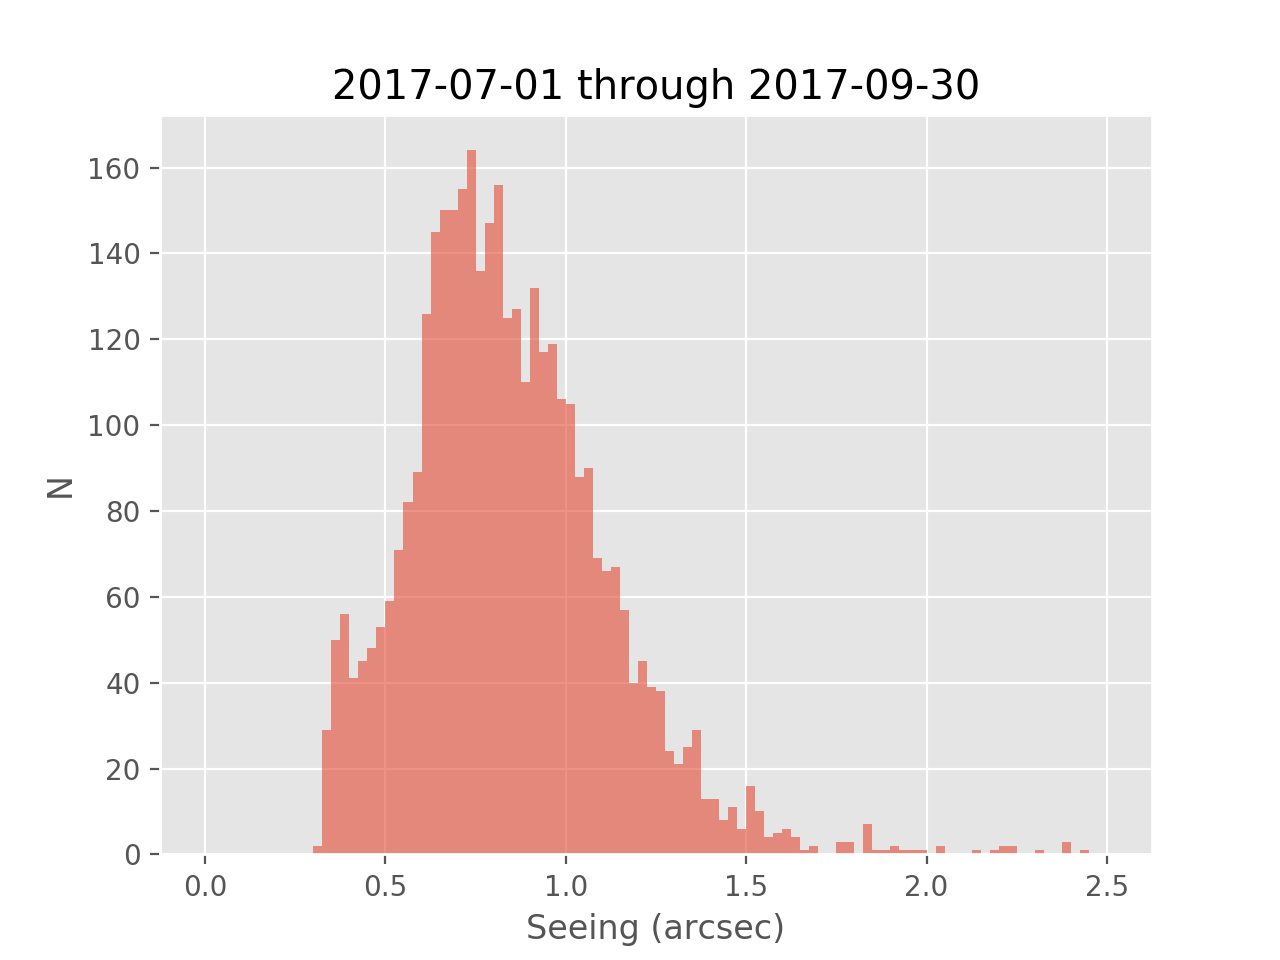

In [8]:
# make raw histogram of the zenith-corrected seeing column
trimdata.hist(column='seeing', bins=100, range=(0.0, 2.5), alpha=0.6)
plt.title("2017-07-01 through 2017-09-30")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.show()

In [9]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = scipy.stats.lognorm.fit(trimdata['seeing'])
x = np.arange(0.0, 2.5, 0.01)
p = scipy.stats.lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.median(trimdata['seeing'])
fit_median = exp_mu + loc

<IPython.core.display.Javascript object>


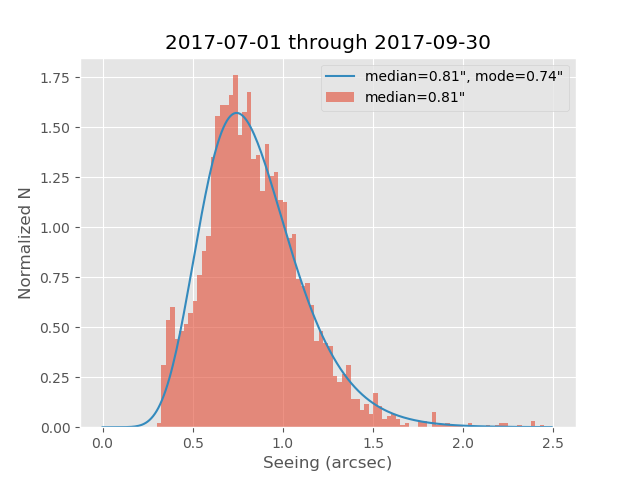

In [12]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
plt.hist(trimdata['seeing'], normed=True, bins=100, range=(0.0, 2.5), label="hist", alpha=0.6)
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Normalized N")
plt.title("2017-07-01 through 2017-09-30")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.show()

<IPython.core.display.Javascript object>


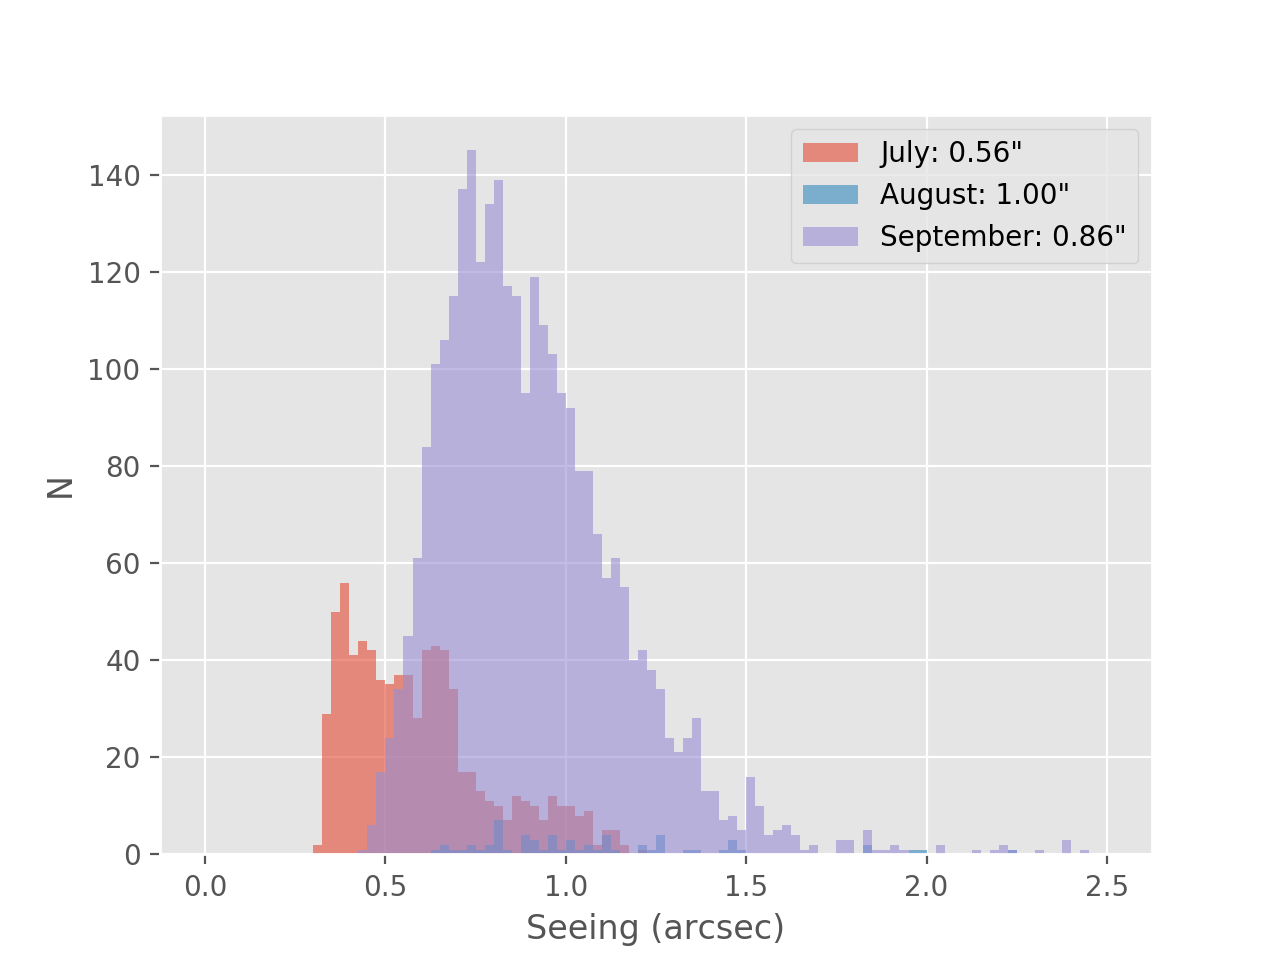

In [11]:
# panda time indexing makes it easy to group by month
months = {}
legends = []
months['July'] = trimdata['2017-07']
months['August'] = trimdata['2017-08']
months['September'] = trimdata['2017-09']
for m in months:
    plt.hist(months[m]['seeing'], bins=100, range=(0.0, 2.5), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.show()

In [15]:
len(months['July']), len(months['August']), len(months['September'])

(777, 62, 2887)

In [50]:
# almost half the total amount of data was from MMIRS in april...
len(trimdata)

13329

In [16]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = trimdata.between_time(start_time='00:00', end_time='07:00')
second_half = trimdata.between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

<IPython.core.display.Javascript object>


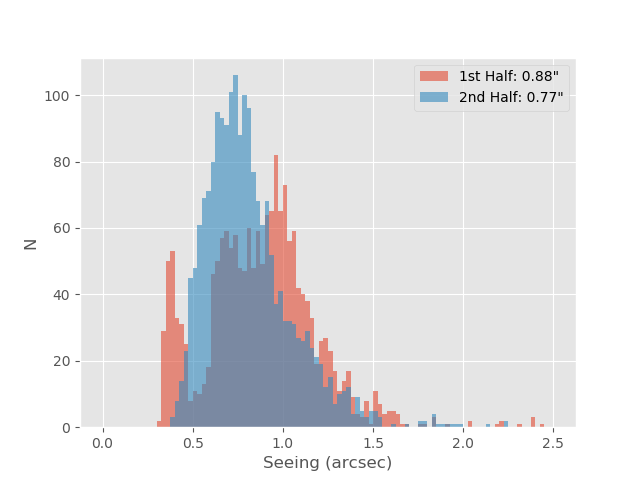

In [17]:
# plot the results and show that the seeing is better later in the night...
plt.hist(first_half['seeing'], bins=100, range=(0.0, 2.5), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 2.5), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.show()

<IPython.core.display.Javascript object>


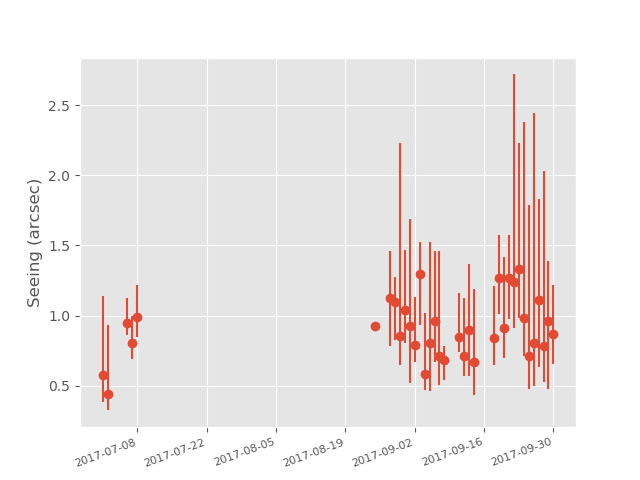

In [14]:
# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = trimdata.seeing.resample('D').median()
daily['max'] = trimdata.seeing.resample('D').max()
daily['min'] = trimdata.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
labels = ax.get_xticklabels()
plt.setp(labels, rotation=20, fontsize=8, ha='right')
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.show()

In [108]:
len(second_half)

6029

In [113]:
len(second_half[second_half['wfs'] =='mmirs'])

5156

In [114]:
len(first_half)

7301

In [117]:
len(first_half[first_half['wfs'] == 'mmirs'])

6006

In [118]:
len(trimdata[trimdata['wfs'] == 'mmirs'])

11144

In [119]:
11144 - 6541

4603

In [120]:
len(months['May']) + len(months['June'])

6125

In [121]:
5156/6029

0.8551998673080112

In [122]:
6006/7301

0.822627037392138

In [123]:
7301/13329

0.5477530197314127